# Fit Hubble Data
Denne notebook genskaber Hubbles regression for hastighed vs. afstand.

Bedste fit for Hubble-konstanten er H0 = 423.9 ± 42.2 km/s/Mpc


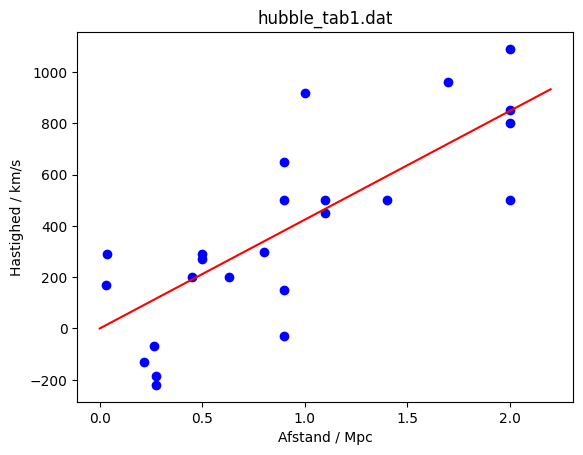

In [4]:
# Load først en række Python-pakke med forskellige redskaber:
import numpy as np                      # Matematik- og array-redskaber
import matplotlib.pyplot as plt         # Forskellige plotteredskaber
from scipy.optimize import curve_fit    # Statistiske redskaber, inkl. fitte-funktionen "curve_fit"
import argparse                         # Pakke til at få funktionen til at tage et filnavn som argument
import sys                              # Pakke til at kalde forksellige "ydre" funktion, som f.eks. `exit`

# Definér en lineær funktion til regression:
def linear(x,a): # Ingen `b`, da vi vil tvinge fittet til at skære (0,0)
    return(a*x)

# Følgende blok er for at gøre funktion i stand til at tage et argument, ------#
# nemlig navnet på en fil med galakse-afstande og hastigheder.                 #
parser = argparse.ArgumentParser(                                              #
    description="Udfør en lineær regression på Hubble-data."                   #
)                                                                              #
parser.add_argument(                                                           #
    "filnavn",                                                                 #
    nargs="?",  # means optional: 0 or 1 values                                #
    help="""Navnet på filen med galaksedata (f.eks. hubble_tab1.dat).\n
    Filen skal have to søjler, hhv. afstand i Mpc og hastighed i km/s."""      #
)                                                                              #
args = parser.parse_args([])      
class Args: pass
args = Args()
args.filnavn = "hubble_tab1.dat"
#
                                                                               #
if args.filnavn is None: # Hvis der mangler et argument                        #
    print("\nHer mangler navnet på en fil med galakse-data.\n")                #
    print("Brug koden sådan her:\n python fit_hubble_arg.py <filnavn>\n")      #
    print("Få mere hjælp med:\n python fit_hubble_arg.py -help\n")             #
    sys.exit(1)                                                                #
else:                                                                          #
    dist_v_file = args.filnavn                                                 #
# På dette tidspunkt er variablen `dist_v_file` en tekststreng med filnavnet --#


# Load dataene fra inputfilen:
dist,vel = np.loadtxt(dist_v_file,unpack=True)


# Fit en lineær funktion til dataene (altså "lineær regression"):
popt,pcov = curve_fit(linear,dist,vel)   # Input er (funktion, x-værdier, y-værdier); output er (hældning, varians på hældning)
H0        = popt[0]                      # curve_fit returnerer arrays af parametre, men i dette tilfælde er der kun ét tal pr. array,
varH0     = pcov[0][0]                   #   fordi den lineære funktion kun har én uafhængig variabel
sigH0     = np.sqrt(varH0)               # Usikkerheden (1 sigma) er kvadratroden af variansen
d_akse    = np.linspace(0,1.1*max(dist)) # Definér en x-akse for afstande til at plotte fittet på
bestfit   = linear(d_akse,H0)            # Linje for bedste fit, baseret på koefficienterne i `coeff`


# Plot data og bedste fit
plt.clf()                                        # Ryd plottevinduet, i tilfælde af at du har plottet noget andet
if len(vel) < 100:                               # Hvis der ikke er så mange galakser...
    plt.scatter(dist,vel,color='b')              # ...så lav en prik for hvert datapunkt ('b' betyder blå)
else:                                            # Men hvis der er mange...
    plt.scatter(dist,vel,color='b',s=1,alpha=.1) # ...så gør prikkerne små og gennemsigtige
plt.plot(d_akse,bestfit,'r')                     # Plot fittet ('r' betyder rød)
plt.xlabel('Afstand / Mpc')                      # Tekst på x-aksen
plt.ylabel('Hastighed / km/s')                   # Tekst på y-aksen
plt.title(dist_v_file)                           # Skriv filnavnet øverst i plottet (praktisk hvis du har flere åbne plots)


# Print resultatet. {:.1f} betyder "kommatal med ét decimal"
print('Bedste fit for Hubble-konstanten er H0 = {:.1f} ± {:.1f} km/s/Mpc'.format(H0,sigH0))


# Hvis du vil have plottet til at ligne Hubbles figur helt, så skriv hubble1929=True i stedet for False nedenfor.
# (men husk, at hvis du plotter andre data med større afstande eller hastigheder, så falder de udenfor plottevinduet)
hubble1929 = False
if hubble1929:
    plt.xlim([-.333,2.333])
    plt.ylim([-333,1333])
    plt.xticks([0,1,2])
    plt.yticks([0,500,1000])
    plt.grid()
    plt.gca().set_axisbelow(True)

plt.show()  # Vis plottevinduet (skal stå nederst, da programmet ikke kører videre)
